https://www.kaggle.com/neuromusic/avocado-prices/version/1

In [1]:
import pandas as pd

df = pd.read_csv('../../data/avocado.csv.zip')
df.shape

(18249, 14)

In [2]:
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [3]:
# replacing spaces with underscores allows us to use dotted-column access (see below)
df.columns = ['_'.join(c.lower().split()) for c in df.columns]
df.head()

,unnamed:_0,date,averageprice,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df['date'] = pd.to_datetime(df.date)

/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='date'>

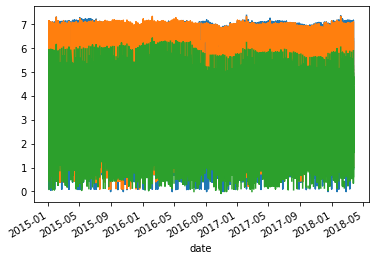

In [5]:
import numpy as np

np.log10(df.set_index('date')['4046']).plot()
np.log10(df.set_index('date')['4225']).plot()
np.log10(df.set_index('date')['4770']).plot()

,id,date,log_total_volume
0,0,2015-01-04,7.519805
1,0,2015-01-11,7.491700
2,0,2015-01-18,7.502464
3,0,2015-01-25,7.509272
4,0,2015-02-01,7.701507
...,...,...,...
502,2,2018-02-25,6.287195
503,2,2018-03-04,6.189226
504,2,2018-03-11,6.280279
505,2,2018-03-18,6.244039


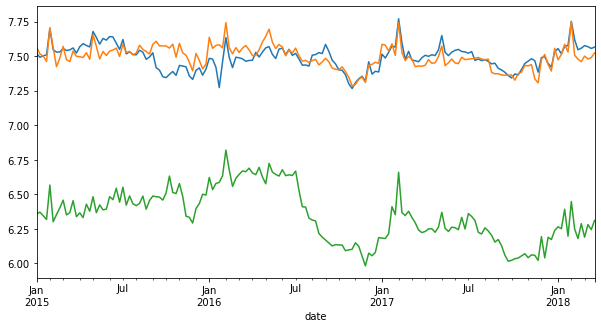

In [6]:
import matplotlib.pyplot as plt


fig, ax= plt.subplots(figsize=(10, 5))

X = pd.concat([
    df.drop('total_volume', axis=1).rename({'4046': 'total_volume'}, axis=1).assign(id=0)[['date', 'id', 'total_volume']],
    df.drop('total_volume', axis=1).rename({'4225': 'total_volume'}, axis=1).assign(id=1)[['date', 'id', 'total_volume']],
    df.drop('total_volume', axis=1).rename({'4770': 'total_volume'}, axis=1).assign(id=2)[['date', 'id', 'total_volume']],
])
X = np.log10(X.set_index('date').groupby(['id', 'date']).sum()).reset_index().rename({'total_volume': 'log_total_volume'}, axis=1)


# X = df.copy()
# X['id'] = df.region.map({r: i for i, r in enumerate(df.region.unique())})
# X['log_total_volume'] = np.log10(X.total_volume)


X.set_index('date').groupby('id').log_total_volume.plot(ax=ax)
X

In [7]:
X.groupby('id').size()

id
0    169
1    169
2    169
dtype: int64

In [8]:
X.reset_index(inplace=True)
X['t'] = (X.date - X.date.min()).dt.days

In [9]:
import sys; sys.path.append('../..')
from tensorflow import keras
from ryan_adams import *

model = RyanAdams(
    trends=[
        LinearTrend(
            n_items=1,
            t_range=(0, X.t.max()),
            name='global_trend',
        ),
        LinearTrend(
            n_items=X.id.nunique(),
            t_range=(0, X.t.max()),
            name='item_trend',
        )
    ],
    seasonalities=[
        Seasonality(n_items=1, period=7, order=3, name='global_weekly_seasonality'),
        Seasonality(n_items=1, period=365.25, order=10, name='global_yearly_seasonality'),
        Seasonality(n_items=X.id.nunique(), period=7, order=3, name='item_weekly_seasonality'),
        Seasonality(n_items=X.id.nunique(), period=365.25, order=10, name='item_yearly_seasonality'),
    ],
    outer_layers=[
        keras.layers.Dense(4, activation='linear'),
        keras.layers.Dense(4, activation='linear'),
        keras.layers.Dense(4, activation='linear'),
    ]
)


2022-08-10 15:36:54.235038: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
Xt = X[['id', 't']].to_dict('series')
history = model._model.fit(
    Xt, X.log_total_volume,
    batch_size=32,
    epochs=200,
    verbose=0)
history.history['loss'][::10]

[611.899658203125,
 32.943748474121094,
 25.812320709228516,
 20.543161392211914,
 15.923812866210938,
 13.226000785827637,
 11.004023551940918,
 9.38986587524414,
 7.92425537109375,
 6.705146312713623,
 5.64772367477417,
 4.775422096252441,
 4.004823207855225,
 3.783660888671875,
 3.693518877029419,
 3.169511318206787,
 2.785175085067749,
 2.595616340637207,
 2.4157588481903076,
 3.5133869647979736]

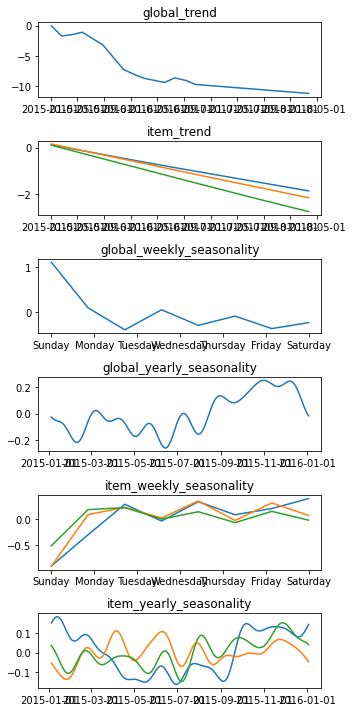

In [11]:
plot_model_components(model, t0=df.date.min())
plt.tight_layout()

In [12]:
X['prediction'] = model.predict(Xt)

id
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: prediction, dtype: object

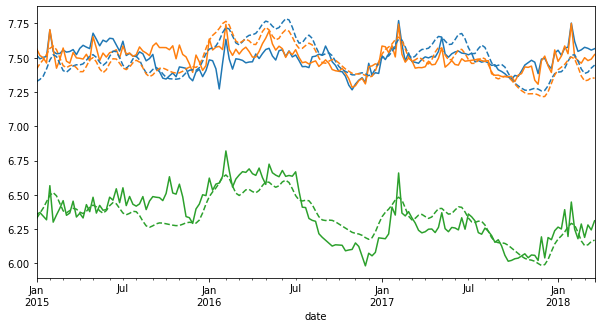

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
X.set_index('date').groupby('id').log_total_volume.plot(ax=ax)

ax.set_prop_cycle(None)
X.set_index('date').groupby('id').prediction.plot(ax=ax, ls='--')